In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#Read Toyota data
data_TM = pd.read_csv('/content/TM.csv')
data_TM

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,67.389999,67.900002,67.309998,67.779999,59.586105,377100
1,2012-01-04,68.230003,68.680000,68.070000,68.430000,60.157532,501600
2,2012-01-05,68.500000,68.830002,68.370003,68.620003,60.324562,343700
3,2012-01-06,68.519997,68.599998,68.220001,68.510002,60.227848,212000
4,2012-01-09,68.500000,68.709999,68.220001,68.419998,60.148735,301700
...,...,...,...,...,...,...,...
2997,2023-11-30,189.529999,190.000000,189.130005,189.779999,189.779999,189400
2998,2023-12-01,190.770004,192.809998,190.369995,192.740005,192.740005,237500
2999,2023-12-04,188.339996,189.110001,187.050003,187.369995,187.369995,331200
3000,2023-12-05,187.699997,188.979996,187.500000,187.990005,187.990005,199600


In [3]:
train_size = int(0.7 * len(data_TM))
test_size = int(0.2 * len(data_TM))
val_size = len(data_TM) - train_size - test_size

train_data = data_TM[:train_size]
test_data = data_TM[train_size:train_size+test_size]
val_data = data_TM[train_size+test_size:]

In [4]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.8 MB/s eta 0:00:00


In [5]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7614.150, Time=3.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7614.759, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7610.979, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7611.050, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7613.423, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7612.907, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7612.888, Time=1.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7614.887, Time=2.34 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7609.713, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7611.633, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7611.614, Time=0.90 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7609.787, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7613.613, Time=1.33 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 11.953 seconds


In [6]:
order = (1, 1, 0)  # ARIMA order
seasonal_order = (0, 0, 0, 0)  # SARIMA order with seasonality
model = SARIMAX(data_TM['Close'], order=order, seasonal_order=seasonal_order)
results = model.fit(disp=False)

In [7]:
# Define SARIMA model
import statsmodels.api as sm
p,d,q = 1,1,0
P,D,Q,s = 0,0,0,0

# Fit SARIMA model
model = sm.tsa.statespace.SARIMAX(data_TM['Close'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model.fit()

In [8]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = results.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=True)
# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_val_pred = results.predict(start=val_data.index[0], end=val_data.index[-1], dynamic=True)

In [9]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  data_TM.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
# Predict for the next 30 days using SARIMA
forecast_steps = 30
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

# Extract the forecasted values for the next 30 days
y_next_30_days = forecast_mean.values
y_next_30_days

array([189.88205019, 189.88208344, 189.8820833 , 189.8820833 ,
       189.8820833 , 189.8820833 , 189.8820833 , 189.8820833 ,
       189.8820833 , 189.8820833 , 189.8820833 , 189.8820833 ,
       189.8820833 , 189.8820833 , 189.8820833 , 189.8820833 ,
       189.8820833 , 189.8820833 , 189.8820833 , 189.8820833 ,
       189.8820833 , 189.8820833 , 189.8820833 , 189.8820833 ,
       189.8820833 , 189.8820833 , 189.8820833 , 189.8820833 ,
       189.8820833 , 189.8820833 ])

In [10]:
# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

test_mae = mean_absolute_error(y_pred, y_test)
test_rmse = np.sqrt(mean_squared_error(y_pred, y_test))
test_mape = mean_absolute_percentage_error(y_pred, y_test)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('---------------------------')
val_mae = mean_absolute_error(y_val_pred, y_val)
val_rmse = np.sqrt(mean_absolute_error(y_val_pred, y_val))
val_mape = mean_absolute_percentage_error(y_val_pred, y_val)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 35.90623256848771
Testing RMSE: 41.47632233762104
Testing MAPE: 0.2916990517956675
---------------------------
Validation MAE: 18.331422386348702
Validation RMSE: 4.281521036541652
Validation MAPE: 0.1351606570583782


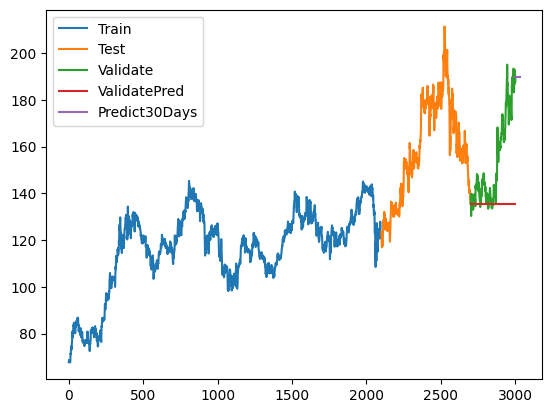

In [11]:
# Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, y_val_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate','ValidatePred','Predict30Days'])
plt.show()